In [16]:
import pandas as pd
import requests
import random
import time
import matplotlib.pyplot as plt

In [17]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0",
    "Accept-Language": 'en-US,en;q=0.9',
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Referer": "https://tiki.vn/",
    "From": "",
    "af-ac-enc-dat": "",
    "x-api-source": "pc"
}

### EXTRACT SUB CATEGORY

In [ ]:
URL = "https://api.tiki.vn/raiden/v2/menu-config?platform=desktop"
response = requests.get(URL, headers=HEADERS)
time.sleep(random.uniform(3.2, 8.7))
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to fetch data:", response.status_code)
    
group = data["menu_block"]["items"]
group_list = []
for group in group:
    link = group["link"]
    group_id = link.split("/")[-1][1:]
    text = group["text"]
    
    if group_id in ["1846", "1789"]:
        group_list.append([group_id, text])

group = pd.DataFrame(group_list, columns=["GroupID", "Name"])

In [ ]:
category_list = []
for group_id, group_name in zip(group["GroupID"], group["Name"]):
    parent_url = f"https://tiki.vn/api/v2/categories?parent_id={group_id}"
    parent_response = requests.get(parent_url, headers=HEADERS)
    time.sleep(random.uniform(3.2, 8.7))
    if parent_response.status_code == 200:
        parent_data = parent_response.json()
        if not parent_data["data"]:
            category_list.append([group_id, group_name, None, None, None, None, None, None])
        else:
            for parent_category in parent_data["data"]:
                parent_id = parent_category["id"]
                parent_name = parent_category["name"]
                
                child_url = f"https://tiki.vn/api/v2/categories?parent_id={parent_id}"
                child_response = requests.get(child_url, headers=HEADERS)
                time.sleep(random.uniform(3.2, 8.7))
                
                if child_response.status_code == 200:
                    child_data = child_response.json()
                    if not child_data["data"]:
                        category_list.append([group_id, group_name, parent_id, parent_name, None, None, None, None])
                    else:
                        for child_category in child_data["data"]:
                            child_id = child_category["id"]
                            child_name = child_category["name"]
                            
                            type_url = f"https://tiki.vn/api/v2/categories?parent_id={child_id}"
                            type_response = requests.get(type_url, headers=HEADERS)
                            time.sleep(random.uniform(3.2, 8.7))
                            
                            if type_response.status_code == 200:
                                type_data = type_response.json()
                                if type_data["data"]:
                                    for type_item in type_data["data"]:
                                        type_id = type_item.get("id")
                                        type_name = type_item.get("name")
                                        category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, type_id, type_name])
                                else:
                                    category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, None, None])

category_df = pd.DataFrame(category_list, columns=["GroupID", "GroupName", "MasterCategoryID", "MasterCategoryName", "CategoryID", "CategoryName", "SubCategoryID", "SubCategoryName"])

In [ ]:
def remove_single_category(df):
    # Group the DataFrame by MasterCategoryID and count the unique CategoryID values
    category_counts = df.groupby('MasterCategoryID')['CategoryID'].nunique()
    
    # Create a mask for MasterCategoryIDs with only one CategoryID
    single_category_mask = category_counts == 1
    
    # Drop the CategoryID and CategoryName columns for rows where there is only one CategoryID
    df.loc[df['MasterCategoryID'].isin(single_category_mask[single_category_mask].index), ['CategoryID', 'CategoryName']] = [None, None]
    
    return df
  
cleaned_df = remove_single_category(category_df)

def transform_category(row):
    # Handle MasterCategory and Category
    if pd.isna(row['CategoryID']):
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['MasterCategoryID']
        category_name = row['MasterCategoryName']
        is_category = 0
    else:
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['CategoryID']
        category_name = row['CategoryName']
        is_category = 1

    # Handle SubCategory
    if pd.isna(row['SubCategoryID']):
        sub_category_id = category_id
        sub_category_name = category_name
        is_sub_category = 0
    else:
        sub_category_id = row['SubCategoryID']
        sub_category_name = row['SubCategoryName']
        is_sub_category = 1

    return pd.Series([
        master_category_id, master_category_name, category_id, category_name,
        is_category, sub_category_id, sub_category_name, is_sub_category
    ])
    
category_df[['MasterCategoryID', 'MasterCategoryName', 'CategoryID', 'CategoryName',
             'isCategory', 'SubCategoryID', 'SubCategoryName', 'isSubCategory']] = category_df.apply(transform_category, axis=1, result_type='expand')

In [ ]:
category_df["GroupID"] = category_df["GroupID"].astype(int)
category_df["MasterCategoryID"] = category_df["MasterCategoryID"].astype(int)
category_df["CategoryID"] = category_df["CategoryID"].astype(int)
category_df["SubCategoryID"] = category_df["SubCategoryID"].astype(int)


master_category = category_df[["MasterCategoryID", "GroupID", "MasterCategoryName"]].drop_duplicates()
master_category = master_category.rename(columns={"MasterCategoryName": "Name"})

category = category_df[["CategoryID", "MasterCategoryID", "CategoryName", "isCategory"]].drop_duplicates()
category = category.rename(columns={"CategoryName": "Name"})

sub_category = category_df[["SubCategoryID", "CategoryID", "SubCategoryName", "isSubCategory"]].drop_duplicates()
sub_category = sub_category.rename(columns={"SubCategoryName": "Name"})

In [ ]:
def retrieve_product_ids(sub_category_id):
    base_url = "https://tiki.vn/api/personalish/v1/blocks/listings"
    PARAMS = {"category": sub_category_id, "page": 1}
    response = requests.get(base_url, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 8.7))
    data = response.json()
    total_page = data["paging"]["last_page"]

    # Fetch data from each page
    product_data = []
    for page in range(1, total_page + 1):
        PARAMS = {"category": sub_category_id, "page": page}
        response = requests.get(base_url, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 8.7))
        data = response.json()
        for item in data["data"]:
            product_id = item["id"]
            brand_name = item.get("brand_name", None)  # Use .get() with a default value in case brand_name is missing
            product_data.append({"product_id": product_id, "brand_name": brand_name})

    return product_data

product_df = []

for sub_category_id in sub_category["SubCategoryID"]:
    product_data = retrieve_product_ids(sub_category_id)
    for product in product_data:
        product_df.append([sub_category_id, product["product_id"], product["brand_name"]])
    
product_df = pd.DataFrame(product_df, columns=["SubCategoryID", "ProductID", "BrandName"])

In [18]:
# # Save it to CSV
product_df = pd.read_csv("data/brand.csv")

In [19]:
# Count the number of ProductID by BrandName
brand_counts = product_df["BrandName"].value_counts()
brand_counts.head(10)

BrandName
OEM            7635
MISUFUJl       1839
HI PC          1748
UGREEN          578
HP              501
Dell            334
Samsung         311
Tenda           298
RONALD JACK     290
TP-Link         241
Name: count, dtype: int64

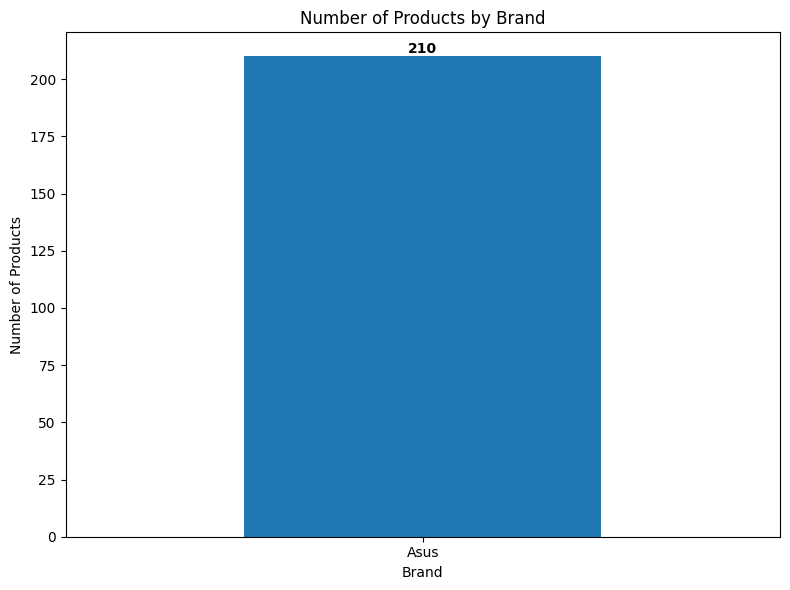

In [20]:
# brands = ['Apple', 'Samsung', 'Asus', 'HP']
brands = ['Asus']
brand_counts = brand_counts[brands]

fig, ax = plt.subplots(figsize=(8, 6))
brand_counts.plot(kind='bar', ax=ax)

for i, v in enumerate(brand_counts):
    ax.text(i, v, str(v), color='black', fontweight='bold', horizontalalignment='center', verticalalignment='bottom')

plt.title('Number of Products by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Products')

plt.xticks(range(len(brands)), brands, rotation=0)

plt.tight_layout()
plt.show()

In [21]:
product_df = product_df[product_df['BrandName'].isin(brands)]
product_df

,SubCategoryID,ProductID,BrandName
618,29010,173151886,Asus
621,29010,189572223,Asus
631,29010,189572199,Asus
689,29010,263753733,Asus
692,29010,273513557,Asus
...,...,...,...
16723,11958,274561334,Asus
17220,28908,14370763,Asus
17223,28908,21162350,Asus
17224,28908,10592531,Asus


In [ ]:
product_df.to_csv("temp.csv", index=False)

### RETRIEVE PRODUCT DATA

In [ ]:
# filtered_df = pd.read_csv("data/product_id.csv")

In [25]:
product_data_list = []

for _, row in product_df.iterrows():
    sub_category_id = row['SubCategoryID']
    product_id = row['ProductID']

    URL = f"https://tiki.vn/api/v2/products/{product_id}"
    PARAMS = {}

    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 4.7))
    
    data = response.json()

    product_data = {
        'product_id': data['id'],
        'product_name': data.get('name', None),
        'product_url': data.get('short_url', None),
        'pricing_current': data.get('price', None),
        'pricing_original': data.get('original_price', None),
        'product_image_url': data.get('thumbnail_url', None),
        'inventory_status': data.get('inventory_status', None),
        'inventory_type': data.get('inventory_type', None),
        'created_date': data.get('day_ago_created', None),
        'quantity_sold': data.get('all_time_quantity_sold', None),
        'brand_id': data.get('brand', {}).get('id', None),
        'brand_name': data.get('brand', {}).get('name', None),
        'brand_slug': data.get('brand', {}).get('slug', None),
        'seller_id': data.get('current_seller', {}).get('id', 0) if data.get('current_seller') else 0,
        'seller_name': data.get('current_seller', {}).get('name', 0) if data.get('current_seller') else 0,
        'seller_link': data.get('current_seller', {}).get('link', 0) if data.get('current_seller') else 0,
        'seller_image_url': data.get('current_seller', {}).get('logo', 0) if data.get('current_seller') else 0,
        'category_id': data['categories']['id'] if data.get('categories') and data['categories'].get('is_leaf') else (data['breadcrumbs'][-2]['category_id'] if data.get('breadcrumbs') else None),
        'sub_category_id': sub_category_id,
        'brand_name': row['BrandName']
    }

    product_data_list.append(product_data)

print(f"Success fetching data for {len(product_data_list)} products")
product_df = pd.DataFrame(product_data_list, columns=['product_id', 'product_name', 'product_url', 'pricing_current', 'pricing_original', 'product_image_url', 'inventory_status', 'inventory_type', 'created_date', 'quantity_sold', 'brand_id', 'brand_name', 'brand_slug', 'seller_id', 'seller_name', 'seller_link', 'seller_image_url', 'category_id', 'sub_category_id', 'brand_name'])
product_df.to_csv("product_data_3.csv", index=False, encoding='utf-8-sig')
product_df.head(10)

Success fetching data for 210 products


,product_id,product_name,product_url,pricing_current,pricing_original,product_image_url,inventory_status,inventory_type,created_date,quantity_sold,brand_id,brand_name,brand_slug,seller_id,seller_name,seller_link,seller_image_url,category_id,sub_category_id,brand_name
0,173151886,Laptop ASUS Vivobook X413JA Core i3-1005G1 / R...,https://tiki.vn/product-p173151886.html?spid=1...,7000000,7000000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,769,NaN,17826,Asus,asus,19749,Hà Nội Lab,https://tiki.vn/cua-hang/ha-noi-lab,b6/ac/8e/008f0082a4a34ee9494e17ab6ac1dc66.png,29010,29010,Asus
1,189572223,Laptop Asus Vivobook F415E i3-1115G4/8GB/128SS...,https://tiki.vn/product-p189572223.html?spid=1...,10750000,10750000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,672,NaN,17826,Asus,asus,1828,Mac&More,https://tiki.vn/cua-hang/mac-more,96/78/d8/675443c104100fd24fee9c57f3f79fa6.jpg,29010,29010,Asus
2,189572199,Laptop Asus VivoBook X515JA Core i3-1005G1/8GB...,https://tiki.vn/product-p189572199.html?spid=1...,10350000,10350000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,672,NaN,17826,Asus,asus,1828,Mac&More,https://tiki.vn/cua-hang/mac-more,96/78/d8/675443c104100fd24fee9c57f3f79fa6.jpg,29010,29010,Asus
3,263753733,Laptop Asus Zenbook 14 OLED UM3402YA - KM074W ...,https://tiki.vn/product-p263753733.html?spid=2...,16190000,21190000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,314,NaN,17826,Asus,asus,52525,An Khang Computer,https://tiki.vn/cua-hang/an-khang-computer,cf/bd/dd/88c80230fb386b035b99f7697378a438.png,29010,29010,Asus
4,273513557,Laptop Asus Vivobook 16 X1605VA-MB105W (Intel ...,https://tiki.vn/product-p273513557.html?spid=2...,14890000,18090000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,157,NaN,17826,Asus,asus,52525,An Khang Computer,https://tiki.vn/cua-hang/an-khang-computer,https://vcdn.tikicdn.com/ts/seller/cf/bd/dd/88...,29010,29010,Asus
5,272354928,Laptop Asus ExpertBook B1 B1402CBA-EK0454W (I3...,https://tiki.vn/product-p272354928.html?spid=2...,9190000,11690000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,222,2.0,17826,Asus,asus,52525,An Khang Computer,https://tiki.vn/cua-hang/an-khang-computer,https://vcdn.tikicdn.com/ts/seller/cf/bd/dd/88...,29010,29010,Asus
6,247443969,Laptop Asus ExpertBook B1500CEAE-BQ3180 i5-113...,https://tiki.vn/product-p247443969.html?spid=2...,17143200,17143200,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,420,NaN,17826,Asus,asus,33284,Ben Computer,https://tiki.vn/cua-hang/ben-computer,c6/a5/1a/5243848c5f08ddcfc08ff0019fe5ed27.jpg,29010,29010,Asus
7,252566338,Laptop Asus Vivobook 15 (X1504VA-NJ069W) / Bạc...,https://tiki.vn/product-p252566338.html?spid=2...,15000000,15000000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,383,NaN,17826,Asus,asus,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,29010,29010,Asus
8,273524532,Laptop Asus Vivobook 14 X1404VA-NK125W (Core i...,https://tiki.vn/product-p273524532.html?spid=2...,13190000,15890000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,155,NaN,17826,Asus,asus,52525,An Khang Computer,https://tiki.vn/cua-hang/an-khang-computer,https://vcdn.tikicdn.com/ts/seller/cf/bd/dd/88...,29010,29010,Asus
9,252566514,Máy Tính Xách Tay Laptop Asus Vivobook 15 Bạc/...,https://tiki.vn/product-p252566514.html?spid=2...,15000000,15000000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,383,NaN,17826,Asus,asus,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,29010,29010,Asus


### RETRIEVE FEEDBACK DATA

In [26]:
feedback_data_list = []
for _, row in product_df.iterrows():
    sub_category_id = row['sub_category_id']
    product_id = row['product_id']
    URL = "https://tiki.vn/api/v2/reviews"
    PARAMS = {"limit": 20, "spid": sub_category_id, "product_id": product_id}

    # Get the total number of pages
    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    data = response.json()
    total_pages = data.get("paging", {}).get("last_page", 1)

    # Fetch data from each page
    for page in range(1, total_pages + 1):
        PARAMS["page"] = page
        response = requests.get(URL, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 4.7))
        data = response.json()

        stars = data.get("stars", {})
        OneStarCount = stars.get("1", {}).get("count", 0)
        TwoStarCount = stars.get("2", {}).get("count", 0)
        ThreeStarCount = stars.get("3", {}).get("count", 0)
        FourStarCount = stars.get("4", {}).get("count", 0)
        FiveStarCount = stars.get("5", {}).get("count", 0)
        reviews_count = data.get("reviews_count", 0)
        review_data = data.get("data", [])

        for review in review_data:
            review_id = review.get("id")
            review_title = review.get("title")
            review_content = review.get("content")
            review_upvote = review.get("thank_count", 0)
            review_rating = review.get("rating")
            review_created_at = review.get("created_at")
            reviewer = review.get("created_by", {})

            if reviewer is not None:
                user_id = reviewer.get("id")
                username = reviewer.get("name")
                joined_time = reviewer.get("created_time")
                total_reviews = reviewer.get("contribute_info", {}).get("summary", {}).get("total_review", 0)
                total_upvotes = reviewer.get("contribute_info", {}).get("summary", {}).get("total_thank", 0)
            else:
                user_id = None
                username = None
                joined_time = None
                total_reviews = 0
                total_upvotes = 0

            feedback_data_list.append([OneStarCount, TwoStarCount, ThreeStarCount, FourStarCount, FiveStarCount,
                                       reviews_count, review_id, review_title, review_content, review_upvote,
                                       review_rating, review_created_at, user_id, username, joined_time,
                                       total_reviews, total_upvotes])

    print(f"Success fetching data for {len(feedback_data_list)} feedbacks")

feedback_df = pd.DataFrame(feedback_data_list, columns=["OneStarCount", "TwoStarCount", "ThreeStarCount", "FourStarCount",
                                                        "FiveStarCount", "reviews_count", "review_id", "review_title",
                                                        "review_content", "review_upvote", "review_rating",
                                                        "review_created_at", "user_id", "username", "joined_time",
                                                        "total_reviews", "total_upvotes"])

feedback_df.to_csv("feedback_data_3.csv", index=False, encoding='utf-8-sig')
feedback_df.head(10)

Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetching data for 0 feedbacks
Success fetc

,OneStarCount,TwoStarCount,ThreeStarCount,FourStarCount,FiveStarCount,reviews_count,review_id,review_title,review_content,review_upvote,review_rating,review_created_at,user_id,username,joined_time,total_reviews,total_upvotes
0,0,0,0,0,1,1,19792205,Cực kì hài lòng,Hàng chuẩn,0,5,1709475366,16347277.0,Dang Trung Uan,2020-02-10 10:44:00,53,3
1,0,0,0,0,5,5,19179222,Cực kì hài lòng,"Màn hình giao an toàn, chất lượng hinh ảnh ok,...",0,5,1683696278,29002035.0,hung minh,2023-03-30 16:51:42,5,1
2,0,0,0,0,5,5,19591230,Cực kì hài lòng,"Giao hàng nhanh, chất lượng cao, màu sắc ổn.",0,5,1697357163,7819104.0,Phạm Dương Minh Quân,2018-08-25 09:49:48,101,4
3,0,0,0,0,5,5,19370074,Cực kì hài lòng,,0,5,1689076201,1200141.0,Nguyễn Thế Nghiệp,2016-03-03 21:17:50,216,3
4,0,0,0,0,5,5,19097557,Cực kì hài lòng,,0,5,1681630291,85465.0,Nguyễn Đức Hạnh,2013-01-09 11:41:02,157,22
5,0,0,0,0,5,5,19063111,Cực kì hài lòng,Ok,1,5,1680846107,13170474.0,Do Ngoc Quy,2019-07-31 11:34:49,5,6
6,0,0,0,0,1,1,18984424,Cực kì hài lòng,,0,5,1679285932,28937331.0,TSAI CHUNG HO,2023-03-11 11:08:41,1,0
7,0,0,0,0,1,1,7997021,Cực kì hài lòng,,0,5,1614304662,1862313.0,VŨ ĐÌNH LAN UYÊN,2016-11-07 15:12:54,45,8
8,0,0,0,1,7,8,15988315,Cực kì hài lòng,"màn hình xài tốt, không lỗi lầm. bữa mình đặt ...",0,5,1650328625,494140.0,Nguyen Chi,2014-11-27 14:51:59,3,0
9,0,0,0,1,7,8,17687510,Cực kì hài lòng,,0,5,1663115015,11329509.0,Hoa Nguyen,2019-03-16 17:01:33,113,4
